In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../..")

import pickle
from pathlib import Path
from typing import Literal

import pandas as pd
import seaborn as sns
from plot_config import savefig

from xlstm_scaling_laws.analysis.parametric_sclaw_fit.plot.plot_scaling_law_fit_grid import (
    get_scaling_law_fit_func_comparison_plot,
)
from xlstm_scaling_laws.analysis.parametric_sclaw_fit.run_fit_grid import (
    load_combined_fit_grid_df,
)

While loading IsoFLOP Runs: Overriding attention flop calc mode to distill_scaling.
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps16400_nb10_ed512_nh4_pf2.667_gbs512, id=0m5bmumq, path=['xlstm', 'xlstm_jax', '0m5bmumq'], created_at=2025-04-13T06:17:04Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_200M_ctx2048_lr0.003_steps3000_nb27_ed896_nh7_pf2.667_gbs512, id=ch1anxyv, path=['xlstm', 'xlstm_jax', 'ch1anxyv'], created_at=2025-04-13T17:35:13Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps27200_nb10_ed512_nh4_pf2.667_gbs512, id=52pij92y, path=['xlstm', 'xlstm_jax', '52pij92y'], created_at=2025-04-13T08:12:40Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_500M_ctx2048_lr0.002_steps9600_nb27_ed1152_nh9_pf2.667_gbs512, id=oyn1hwkt, path=['xlstm', 'xlstm_jax', 'oyn1hwkt'], created_at=2025-04-14T17:41:

# L(N,D) scaling law fit plots - Different fit functions (with/without Gamma)

In [2]:
data_dir_lnd_fits = "../../data_lnd_fits"

In [3]:
def load_combined_fit_grids_gamma_df(
    save_dir=data_dir_lnd_fits,
    use_logsumexp=True,
    huber_delta=1e-3,
    context_length=8192,
    sort_by: str = "tokenparam#mse",
) -> dict[Literal["gamma", "nogamma"], pd.DataFrame]:
    """
    Load the combined fit grids for gamma and nogamma.
    """
    # Load the fit grid dataframes
    fit_grid_dfs = {
        "gamma": load_combined_fit_grid_df(
            save_dir=save_dir,
            use_logsumexp=use_logsumexp,
            huber_delta=huber_delta,
            fit_gamma=True,
            context_length=context_length,
        ).sort_values(by=("val_results", sort_by)),
        "nogamma": load_combined_fit_grid_df(
            save_dir=save_dir,
            use_logsumexp=use_logsumexp,
            huber_delta=huber_delta,
            fit_gamma=False,
            context_length=context_length,
        ).sort_values(by=("val_results", sort_by)),
    }
    return fit_grid_dfs

In [4]:
df_dict = load_combined_fit_grids_gamma_df(
    save_dir=data_dir_lnd_fits,
    use_logsumexp=True,
    huber_delta=1e-3,
    context_length=8192,
)
df_dict["gamma"]

idxes                \
                                            init_idx bootstrap_idx   
model_type experiment_set token_param_range                          
llama      isoflop        0-5000                5796             0   
                          0-5000                6654             0   
                          0-5000                5335             0   
                          0-5000                4433             0   
                          0-5000                2262             0   
...                                              ...           ...   
           tokenparam     0-100                 6104             0   
                          0-100                 4354             0   
                          0-100                 1829             0   
                          0-100                 4254             0   
                          0-100                 1504             0   

                                              val_results                      \
                                            all#r_squared   all#mse  all#rmse   
model_type experiment_set token_param_range                                     
llama      isoflop        0-5000              -241.281723  0.134973  0.367386   
                          0-5000              -241.283983  0.134974  0.367388   
                          0-5000              -241.283954  0.134974  0.367388   
                          0-5000              -241.282001  0.134973  0.367386   
                          0-5000              -241.284140  0.134974  0.367388   
...                                                   ...       ...       ...   
           tokenparam     0-100               -199.858018  0.128606  0.358617   
                          0-100               -199.860062  0.128607  0.358619   
                          0-100               -199.881888  0.128621  0.358638   
                          0-100               -199.838753  0.128594  0.358600   
                          0-100               -199.881501  0.128621  0.358638   

                                                                            \
                                              all#mae tokenparam#r_squared   
model_type experiment_set token_param_range                                  
llama      isoflop        0-5000             0.292091           -50.764433   
                          0-5000             0.292093           -50.764715   
                          0-5000             0.292093           -50.764859   
                          0-5000             0.292091           -50.765253   
                          0-5000             0.292093           -50.765357   
...                                               ...                  ...   
           tokenparam     0-100              0.277583           -29.124694   
                          0-100              0.277585           -29.124711   
                          0-100              0.277601           -29.124734   
                          0-100              0.277569           -29.124796   
                          0-100              0.277601           -29.124806   

                                                                            \
                                            tokenparam#mse tokenparam#rmse   
model_type experiment_set token_param_range                                  
llama      isoflop        0-5000                  0.154675        0.393287   
                          0-5000                  0.154675        0.393288   
                          0-5000                  0.154676        0.393289   
                          0-5000                  0.154677        0.393290   
                          0-5000                  0.154677        0.393290   
...                                                    ...             ...   
           tokenparam     0-100                   0.261810        0.511673   
                          0-100                   0.261810

In [5]:
from itertools import product

from plot_config import savefig


def generate_scaling_law_gamma_nogamma_plots(
    fit_dir: Path,
    experiment_sets: list[str] = ["tokenparam", "all", "isoflop"],
    filename: str = "lnd_scaling_law_fit_gamma_func",
    huber_delta: float = 1e-3,
    x_axis_mode: str = "token_param_ratio",
    sort_by: str = "tokenparam#mse",
):
    for (exp_set,) in product(experiment_sets):
        df = load_combined_fit_grids_gamma_df(
            save_dir=fit_dir,
            use_logsumexp=True,
            huber_delta=huber_delta,
            context_length=8192,
            sort_by=sort_by,
        )

        full_filename = f"{filename}__expset_{exp_set}_xaxis_{x_axis_mode}__huber_delta_{huber_delta:.5f}"
        with sns.plotting_context("notebook", font_scale=1.0):
            with sns.axes_style("whitegrid"):
                fig = get_scaling_law_fit_func_comparison_plot(
                    combined_fit_grid_gamma_dict_df=df,
                    experiment_sets=[exp_set],
                    x_axis_mode=x_axis_mode,
                    title_fontsize=14,
                    # token_param_ranges=["0-5000"],
                )
                # fig.suptitle(
                #     f"Fit on {exp_set}, huber_delta={huber_delta:.1e}, sort_by={sort_by}",
                #     fontsize=16,
                # )

        print(f"Saving {full_filename}...")
        savefig(
            fig,
            filename=full_filename,
        )

/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks/paper_plots/../../xlstm_scaling_laws/analysis/parametric_sclaw_fit/plot/plot_scaling_law_fit_grid.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  gamma_key: combined_fit_grid_gamma_dict_df[gamma_key].loc[model_tag, experiment_set, token_param_range]
/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks/paper_plots/../../xlstm_scaling_laws/analysis/parametric_sclaw_fit/plot/plot_scaling_law_fit_grid.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  gamma_key: combined_fit_grid_gamma_dict_df[gamma_key].loc[model_tag, experiment_set, token_param_range]


Saving lnd_scaling_law_fit_gamma_func__expset_tokenparam_xaxis_token_param_ratio__huber_delta_0.00100...


/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks/paper_plots/../../xlstm_scaling_laws/analysis/parametric_sclaw_fit/plot/plot_scaling_law_fit_grid.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  gamma_key: combined_fit_grid_gamma_dict_df[gamma_key].loc[model_tag, experiment_set, token_param_range]
/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks/paper_plots/../../xlstm_scaling_laws/analysis/parametric_sclaw_fit/plot/plot_scaling_law_fit_grid.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  gamma_key: combined_fit_grid_gamma_dict_df[gamma_key].loc[model_tag, experiment_set, token_param_range]


Saving lnd_scaling_law_fit_gamma_func__expset_all_xaxis_token_param_ratio__huber_delta_0.00100...


/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks/paper_plots/../../xlstm_scaling_laws/analysis/parametric_sclaw_fit/plot/plot_scaling_law_fit_grid.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  gamma_key: combined_fit_grid_gamma_dict_df[gamma_key].loc[model_tag, experiment_set, token_param_range]
/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks/paper_plots/../../xlstm_scaling_laws/analysis/parametric_sclaw_fit/plot/plot_scaling_law_fit_grid.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  gamma_key: combined_fit_grid_gamma_dict_df[gamma_key].loc[model_tag, experiment_set, token_param_range]


Saving lnd_scaling_law_fit_gamma_func__expset_isoflop_xaxis_token_param_ratio__huber_delta_0.00100...


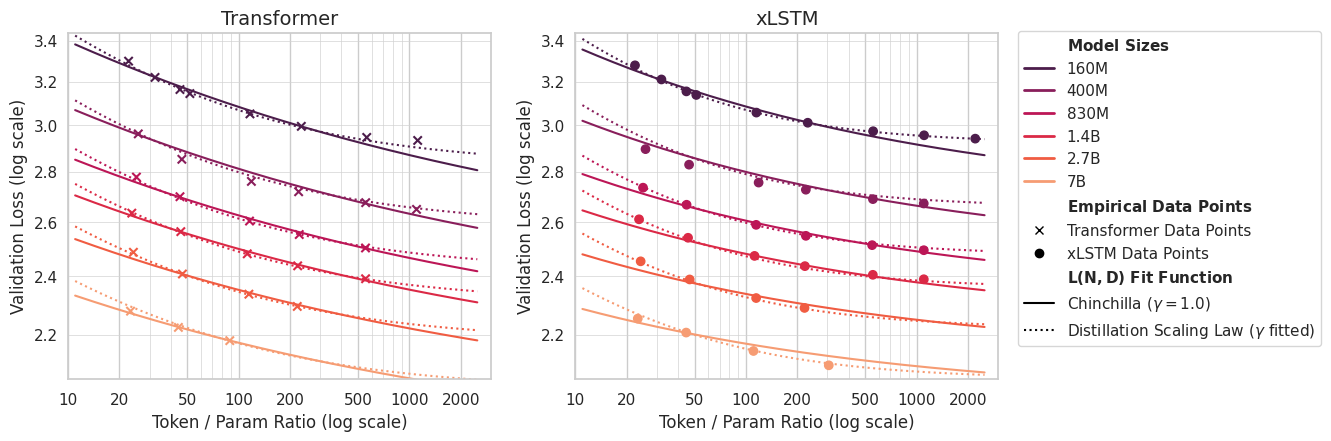

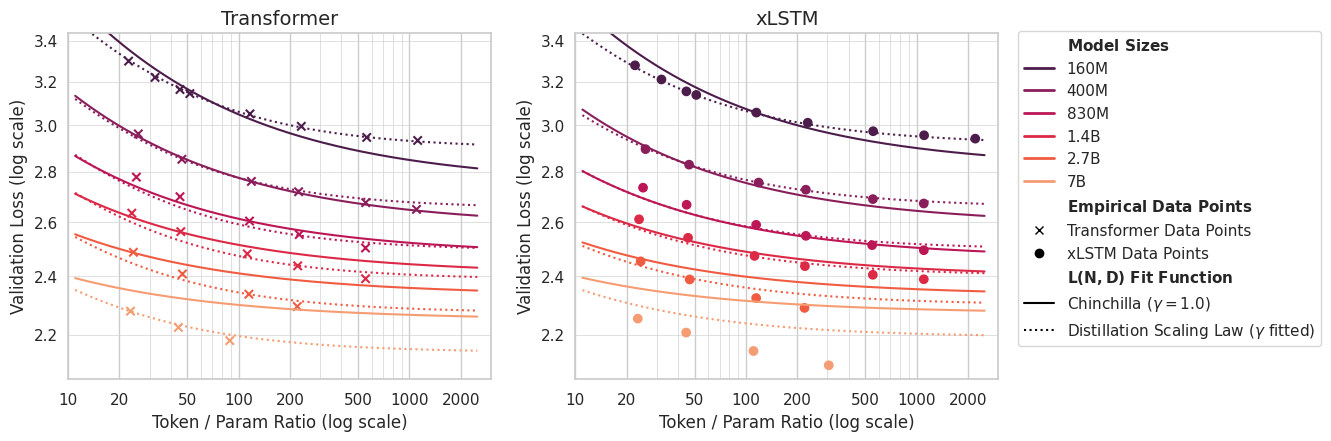

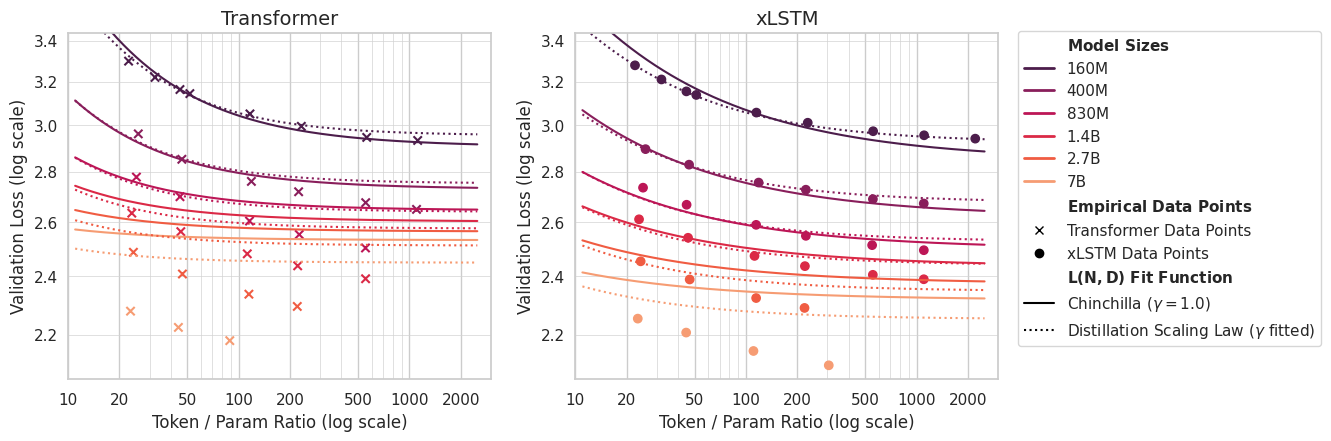

In [6]:
generate_scaling_law_gamma_nogamma_plots(
    fit_dir=Path(data_dir_lnd_fits), x_axis_mode="token_param_ratio"
)